In [15]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import astropy.io.fits as pyfits
import pickle
import sys

"""
With the GALAH survey range, we can use up to 4 CCDS.
With The Cannon, we have a fixed wavelength GRID, onto which we interpolate all spectra.
We can switch between them with the keyword include_ccd4
"""

include_ccd4=True

ccd1=np.arange(4715.94,4896.00,0.046) # ab lines 4716.3 - 4892.3
ccd2=np.arange(5650.06,5868.25,0.055) # ab lines 5646.0 - 5867.8
ccd3=np.arange(6480.52,6733.92,0.064) # ab lines 6481.6 - 6733.4

if include_ccd4==True:
    # Define the 4 CCD grids for the Cannon leaving at least 200 km/s to ab lines and 1 pixel
    ccd4=np.arange(7693.50,7875.55,0.074) # ab lines 7691.2 - 7838.5
    grid=np.array(np.concatenate((ccd1,ccd2,ccd3,ccd4)))
    ccd_nr = 4
else:
    grid=np.array(np.concatenate((ccd1,ccd2,ccd3)))
    ccd_nr = 3

mask = {}
mask['wave'] = grid

In [16]:
"""
Here we read in the Appendix I (file 'APPI') from the CD attached to the
VISIBLE AND NEAR INFRARED ATLAS OF THE ARCTURUS SPECTRUM 3727 - 9300 Å
by Hinkle, Wallace, Valenyi & Harmer
"""

door = open('APPI_lines')
APPI = np.genfromtxt(door,dtype=[('elem','<S5'),('lambda','f8')],delimiter=',',usecols=(0,1),unpack=1)
door.close()

unique_elem_ion = np.unique(APPI['elem'])
unique_elem = np.unique([APPI['elem'][x][:2] for x in range(len(APPI['elem']))])

lines = {}
for each_unique_elem_ion in unique_elem_ion:
    lines[each_unique_elem_ion.replace(' ', '')] = APPI['lambda'][APPI['elem'] == each_unique_elem_ion]
    
lines['LiI'] = np.array([6707.7635])

In [17]:
"""

What we want at the end is files with all elements, 
with all ionisation stages with bitmask 0 or 1 along the wavelength GRID.

Hence, we create np.zero arrays and loop through them, setting a pixel to 1, 
when a line of the given element at a given ionisation stage is closter than 
the line_mask_width in Ångström.

"""

line_mask_width = 0.5 # [Å] full window is +- width, i.e. window = 1.0 Å, if width = 0.5 Å

for each_unique_elem in unique_elem:
    print(each_unique_elem)
    short_each = each_unique_elem.replace(' ','')
    mask[short_each] = np.zeros(len(grid))
    try:
        print('Checking '+short_each+'I: '+str(len(lines[short_each+'I']))+' lines')
        for each_pixel,each_pixel_wave in enumerate(mask['wave']):
            if np.any(abs(each_pixel_wave - lines[short_each+'I']) < line_mask_width):
                mask[short_each][each_pixel] = 1.
    except:
        print('No '+short_each+'I')
    try:
        print('Checking '+short_each+'II: '+str(len(lines[short_each+'II']))+' lines')
        for each_pixel,each_pixel_wave in enumerate(mask['wave']):
            if np.any(abs(each_pixel_wave - lines[short_each+'II']) < line_mask_width):
                mask[short_each][each_pixel] = 1.
    except:
        print('No '+short_each+'II')

# Also create the mask for the combined Alpha_fe label
mask['Alpha_fe'] = mask['O'] + mask['Mg'] + mask['Si'] + mask['Ca'] + mask['Ti']
mask['Alpha_fe'][mask['Alpha_fe'] > 1.] = 1.

# Simply save the masks to individual text files
for each_element in mask.keys():
    np.savetxt('masks_'+str(ccd_nr)+'ccds/mask_'+str(ccd_nr)+'ccds_'+each_element+'.txt',mask[each_element],fmt='%f')

Al
Checking AlI: 18 lines
No AlII
Ba
Checking BaI: 1 lines
Checking BaII: 11 lines
C 
Checking CI: 14 lines
No CII
Ca
Checking CaI: 109 lines
Checking CaII: 13 lines
Ce
No CeI
Checking CeII: 156 lines
Co
Checking CoI: 326 lines
Checking CoII: 1 lines
Cr
Checking CrI: 629 lines
Checking CrII: 71 lines
Cu
Checking CuI: 11 lines
No CuII
Dy
No DyI
Checking DyII: 15 lines
Eu
Checking EuI: 1 lines
Checking EuII: 17 lines
Fe
Checking FeI: 3077 lines
Checking FeII: 141 lines
Gd
No GdI
Checking GdII: 23 lines
H 
No HI
No HII
Hf
No HfI
Checking HfII: 3 lines
K 
Checking KI: 8 lines
No KII
La
No LaI
Checking LaII: 52 lines
Mg
Checking MgI: 66 lines
Checking MgII: 6 lines
Mn
Checking MnI: 179 lines
No MnII
Mo
Checking MoI: 14 lines
No MoII
Na
Checking NaI: 21 lines
No NaII
Nb
Checking NbI: 8 lines
Checking NbII: 1 lines
Nd
No NdI
Checking NdII: 200 lines
Ni
Checking NiI: 535 lines
Checking NiII: 1 lines
O 
Checking OI: 9 lines
No OII
Pb
Checking PbI: 1 lines
No PbII
Pd
Checking PdI: 2 lines
No PdI

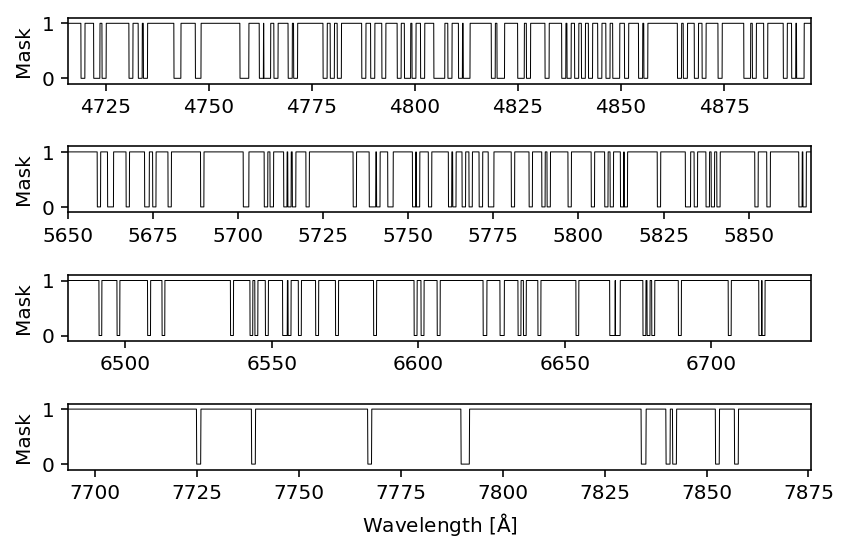

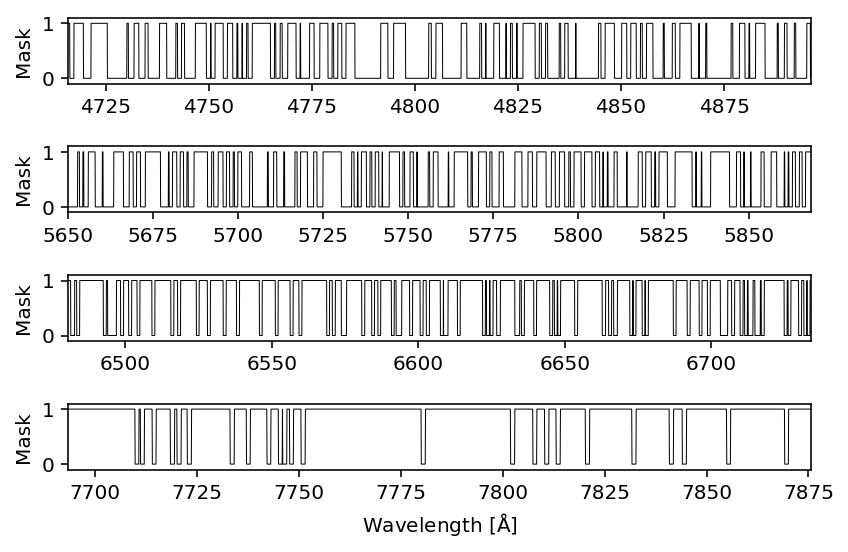

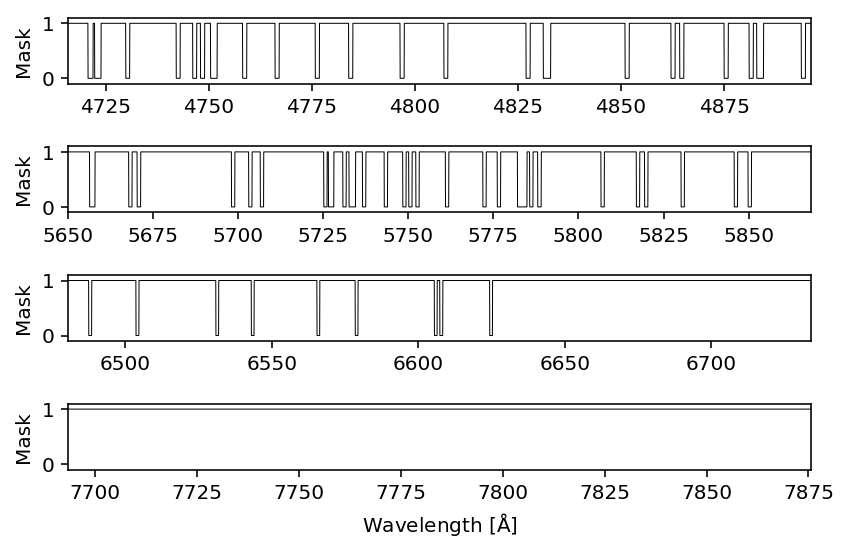

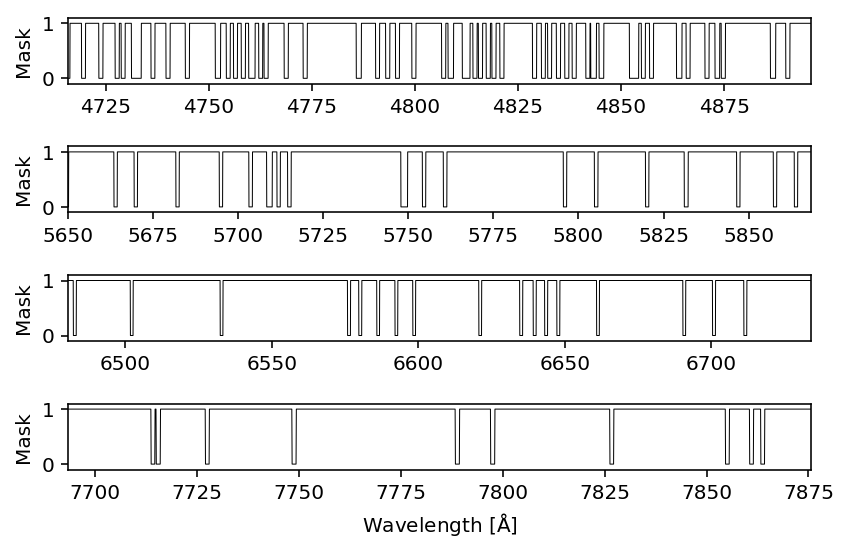

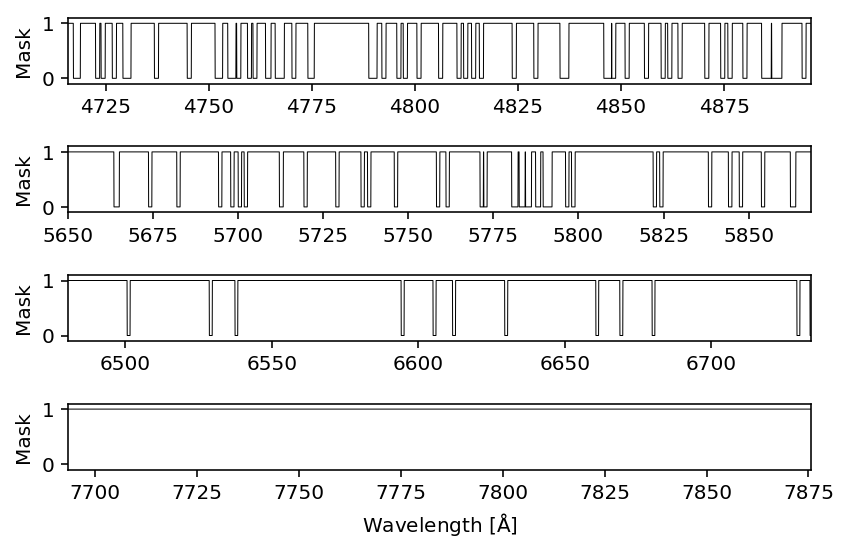

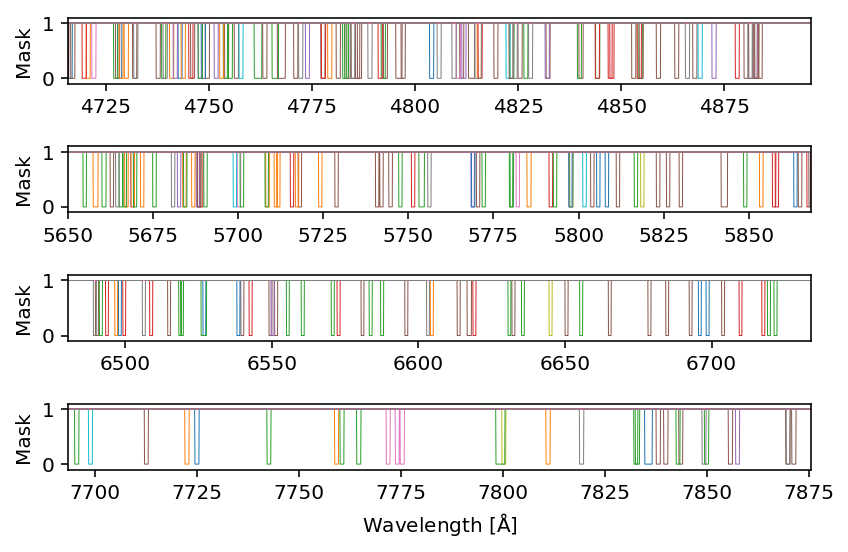

In [18]:
# Here we plot the overview of the 5 most numerous lines and the other lines across the GALAH wavelength range

many_element_lines = ['Ti','Fe','V','Ni','Cr']

kwargs = dict(lw=0.5)

# First the elements with numerous lines
for each_element in many_element_lines:
    f,(ax1,ax2,ax3,ax4) = plt.subplots(4)
    ax1.plot(mask['wave'],1-mask[each_element],'k',**kwargs)
    ax1.set_xlim(ccd1[0],ccd1[-1])
    ax1.set_ylim(-0.1,1.1)
    ax2.plot(mask['wave'],1-mask[each_element],'k',**kwargs)
    ax2.set_xlim(ccd2[0],ccd2[-1])
    ax2.set_ylim(-0.1,1.1)
    ax3.plot(mask['wave'],1-mask[each_element],'k',**kwargs)
    ax3.set_xlim(ccd3[0],ccd3[-1])
    ax3.set_ylim(-0.1,1.1)
    ax4.plot(mask['wave'],1-mask[each_element],'k',**kwargs)
    ax4.set_xlim(ccd4[0],ccd4[-1])
    ax4.set_ylim(-0.1,1.1)
    ax4.set_xlabel(r'Wavelength [$\mathrm{\AA}$]'); ax1.set_ylabel('Mask'); ax2.set_ylabel('Mask'); ax3.set_ylabel('Mask'); ax4.set_ylabel('Mask'); 
    plt.tight_layout()
    plt.savefig('masks_'+str(ccd_nr)+'ccds/GALAH_lines_'+str(ccd_nr)+'ccds'+each_element+'.pdf')

# Last all other elements
f,(ax1,ax2,ax3,ax4) = plt.subplots(4)
for each_element in unique_elem:
    each_element = each_element.replace(' ','')
    if (len(np.where(mask[each_element] == True)[0]) > 0) & (each_element not in many_element_lines):
        ax1.plot(mask['wave'],1-mask[each_element],**kwargs)
        ax1.set_xlim(ccd1[0],ccd1[-1])
        ax1.set_ylim(-0.1,1.1)
        ax2.plot(mask['wave'],1-mask[each_element],**kwargs)
        ax2.set_xlim(ccd2[0],ccd2[-1])
        ax2.set_ylim(-0.1,1.1)
        ax3.plot(mask['wave'],1-mask[each_element],**kwargs)
        ax3.set_xlim(ccd3[0],ccd3[-1])
        ax3.set_ylim(-0.1,1.1)
        ax4.plot(mask['wave'],1-mask[each_element],**kwargs)
        ax4.set_xlim(ccd4[0],ccd4[-1])
        ax4.set_ylim(-0.1,1.1)
        ax4.set_xlabel(r'Wavelength [$\mathrm{\AA}$]'); ax1.set_ylabel('Mask'); ax2.set_ylabel('Mask'); ax3.set_ylabel('Mask'); ax4.set_ylabel('Mask'); 
        plt.tight_layout()
        plt.savefig('masks_'+str(ccd_nr)+'ccds/GALAH_lines_'+str(ccd_nr)+'ccds_all_others.pdf')